In [ ]:
!pip install rasterio

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


class DoubleConvolution(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=1,
        features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for f in features:
            self.downs.append(DoubleConvolution(input_channels, f))
            input_channels = f

        # lower bottleneck layers
        self.bottleneck = DoubleConvolution(features[-1], features[-1] * 2)

        # Decoder
        for f in reversed(features):
            self.ups.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(
                        in_channels=2 * f, out_channels=f, kernel_size=3, padding=1
                    ),
                )
            )
            self.ups.append(DoubleConvolution(2 * f, f))

        self.final_convolution = nn.Conv2d(
            in_channels=features[0],
            out_channels=output_channels,
            kernel_size=3,
            padding=1,
        )

    def forward(self, x):
        skip_connections = list()
        for module in self.downs:
            x = module(x)
            skip_connections.append(x)
            x = self.pool(x)

        skip_connections = skip_connections[::-1]  # reverse order

        x = self.bottleneck(x)

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]
            if skip_connection.shape != x.shape:
                x = TF.resize(
                    x,
                    size=skip_connection.shape[2:],
                    interpolation=TF.InterpolationMode.NEAREST,
                )
            x = torch.cat([skip_connection, x], dim=1)
            x = self.ups[i + 1](x)

        x = self.final_convolution(x)

        return x

In [ ]:
import numpy as np
import torchvision.transforms.functional as F


class RandomVerticalFlip2Images():
    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, images):
        image, label = images
        if np.random.rand() < self.p:
            image = F.vflip(image)
            label = F.vflip(label)
        return image, label


class RandomHorizontalFlip2Images():
    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, images):
        image, label = images
        if np.random.rand() < self.p:
            image = F.hflip(image)
            label = F.hflip(label)
        return image, label


class RandomRotation2Images():
    def __init__(self, degrees: float = 90):
        self.degrees = degrees

    def __call__(self, images):
        image, label = images
        angle = np.random.uniform(-self.degrees, self.degrees)
        image = F.rotate(image, angle)
        label = F.rotate(label, angle)
        return image, label

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import os

import rasterio


class CloudDataset(Dataset):
    def __init__(self, images, labels, transform_image=None, transform_label=None, augment=None):
        self.images = images
        self.labels = labels
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        image = rasterio.open(self.images[idx]).read()
        label = rasterio.open(self.labels[idx]).read()

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        image = np.moveaxis(image, 0, -1)
        label = np.moveaxis(label, 0, -1)

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_label:
            label = self.transform_label(label)
        if self.augment:
            image, label = self.augment((image, label))

        return image, label

In [ ]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(loader):
        print(f"Train batch {batch_idx}/{len(loader)}")

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    return train_loss / len(loader)

In [ ]:
def test(model, loader, criterion, device):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            print(f"Test batch {batch_idx}/{len(loader)}")

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

    return test_loss / len(loader)

In [ ]:
def compute_dataset_info(train_images, train_labels, val_images, val_labels, test_images, test_labels):
    dataset_info = {
        "num_positives": 0,
        "num_negatives": 0,
        "mean": [0.0] * 13,
        "std": [0.0] * 13,
    }

    for images, labels in [
        (train_images, train_labels),
        (val_images, val_labels),
        (test_images, test_labels),
    ]:
        for image, label in zip(images, labels):
            try:
                label = rasterio.open(label).read()
                label = np.moveaxis(label, 0, -1)
                label = label.astype(np.float32)
                dataset_info["num_positives"] += np.sum(label)
                dataset_info["num_negatives"] += np.prod(label.shape) - np.sum(label)
            except Exception as e:
                print(e)
                print(label)

            try:
                image = rasterio.open(image).read()
                image = np.moveaxis(image, 0, -1)
                image = image.astype(np.float32)
                dataset_info["mean"] += np.mean(image, axis=(0, 1))
                dataset_info["std"] += np.std(image, axis=(0, 1))
            except Exception as e:
                print(e)
                print(image)


    dataset_info["mean"] /= (
        len(train_images) + len(test_images)
    )
    dataset_info["std"] /= (
        len(train_images) + len(test_images)
    )

    return dataset_info

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

import random


SEED = 42
BATCH_SIZE = 4
NUM_EPOCHS = 10
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
NUM_WORKERS = 0 if os.name == "nt" else 2
DATA_DIR = os.path.join("drive", "MyDrive", "data")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
DATASET_INFO_PATH = os.path.join(DATA_DIR, "dataset_info.pt")
CHECKPOINTS_DIR = os.path.join("drive", "MyDrive", "checkpoints")
VALIDATION_PERCENTAGE = 0.2
VALIDATION_LIMIT_PERCENTAGE = 0.1
TEST_LIMIT_PERCENTAGE = 0.1

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

train_and_val_images = []
for path in os.listdir(TRAIN_DIR):
    for img in os.listdir(os.path.join(TRAIN_DIR, path, "image")):
        if not ".ipynb_checkpoints" in img:
            train_and_val_images.append(os.path.join(TRAIN_DIR, path, "image", img))

train_images = train_and_val_images[: int(len(train_and_val_images) * (1 - VALIDATION_PERCENTAGE))]
val_images = train_and_val_images[int(len(train_and_val_images) * (1 - VALIDATION_PERCENTAGE)) :]
val_images = random.sample(val_images, int(len(val_images) * VALIDATION_LIMIT_PERCENTAGE))
train_labels = [path.replace("image", "label") for path in train_images]
val_labels = [path.replace("image", "label") for path in val_images]

test_images = []
for path in os.listdir(TEST_DIR):
    for img in os.listdir(os.path.join(TEST_DIR, path, "image")):
        if not ".ipynb_checkpoints" in img:
            test_images.append(os.path.join(TEST_DIR, path, "image", img))

test_images = random.sample(test_images, int(len(test_images) * TEST_LIMIT_PERCENTAGE))
test_labels = [path.replace("image", "label") for path in test_images]

if not os.path.exists(DATASET_INFO_PATH):
    dataset_info = compute_dataset_info(train_images, train_labels, val_images, val_labels, test_images, test_labels)
    torch.save(dataset_info, DATASET_INFO_PATH)

dataset_info = torch.load(DATASET_INFO_PATH)

transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(dataset_info["mean"], dataset_info["std"]),
])
transform_label = transforms.Compose([
    transforms.ToTensor(),
])
augment = transforms.Compose([
    RandomHorizontalFlip2Images(0.5),
    RandomVerticalFlip2Images(0.5),
    RandomRotation2Images(90),
])

train_dataset = CloudDataset(train_images, train_labels, transform_image, transform_label, augment)
val_dataset = CloudDataset(val_images, val_labels, transform_image, transform_label)
test_dataset = CloudDataset(test_images, test_labels, transform_image, transform_label)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = UNet(input_channels=13, output_channels=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(dataset_info["num_negatives"] / dataset_info["num_positives"]).to(DEVICE)
)

print("Number of cloud pixels:", dataset_info["num_positives"])
print("Number of non-cloud pixels:", dataset_info["num_negatives"])

Number of cloud pixels: 576936248.0
Number of non-cloud pixels: 3763238152.0


In [ ]:
train_losses_over_epochs = []
val_losses_over_epochs = []
train_losses_over_sizes = []
val_losses_over_sizes = []

train_percentages = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]

for train_percentage in train_percentages:
    print(f"Train percentage: {train_percentage}")
    train_dataset = CloudDataset(
        train_images[: int(len(train_images) * train_percentage)],
        train_labels[: int(len(train_images) * train_percentage)],
        transform_image,
        transform_label,
        augment,
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    model = UNet(input_channels=13, output_channels=1).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor(dataset_info["num_negatives"] / dataset_info["num_positives"]).to(DEVICE)
    )

    for epoch in range(NUM_EPOCHS):
        os.makedirs(os.path.join(CHECKPOINTS_DIR, f"{round(train_percentage * 1000):03d}", f"epoch_{epoch}"), exist_ok=True)
        checkpoint_path = os.path.join(CHECKPOINTS_DIR, f"{round(train_percentage * 1000):03d}", f"epoch_{epoch}", "unet.pt")
        checkpoint = {}

        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        else:
            train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
            val_loss = test(model, val_loader, criterion, DEVICE)

            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_loss,
                "val_loss": val_loss,
            }
            torch.save(checkpoint, checkpoint_path)

        if train_percentage == train_percentages[-1]:
            train_losses_over_epochs.append(checkpoint["train_loss"])
            val_losses_over_epochs.append(checkpoint["val_loss"])

        if epoch == NUM_EPOCHS - 1:
            train_losses_over_sizes.append(checkpoint["train_loss"])
            val_losses_over_sizes.append(checkpoint["val_loss"])

        print(f"Epoch: {epoch}, train loss: {checkpoint['train_loss']:.3f}, validation loss: {checkpoint['val_loss']:.3f}")

Train percentage: 0.001
Epoch: 0, train loss: 1.130, validation loss: 335.349
Epoch: 1, train loss: 0.921, validation loss: 494.241
Epoch: 2, train loss: 0.660, validation loss: 92.368
Epoch: 3, train loss: 0.753, validation loss: 39.159
Epoch: 4, train loss: 0.621, validation loss: 9.575
Epoch: 5, train loss: 0.435, validation loss: 4.036
Epoch: 6, train loss: 0.538, validation loss: 1.074
Epoch: 7, train loss: 0.471, validation loss: 1.093
Epoch: 8, train loss: 0.391, validation loss: 0.417
Epoch: 9, train loss: 0.550, validation loss: 0.876
Train percentage: 0.002
Epoch: 0, train loss: 1.105, validation loss: 1022.055
Epoch: 1, train loss: 1.119, validation loss: 17.483
Epoch: 2, train loss: 0.804, validation loss: 1.923
Epoch: 3, train loss: 0.773, validation loss: 0.575
Epoch: 4, train loss: 0.812, validation loss: 0.528
Epoch: 5, train loss: 0.590, validation loss: 0.433
Epoch: 6, train loss: 0.495, validation loss: 0.535
Epoch: 7, train loss: 0.601, validation loss: 0.514
Epoch:

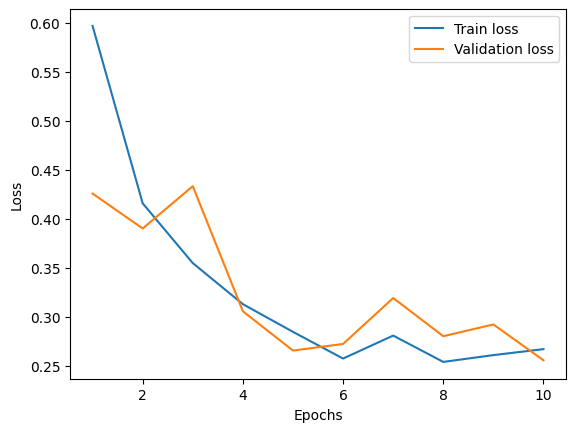

In [ ]:
 import matplotlib.pyplot as plt

plt.plot(range(1, NUM_EPOCHS + 1), train_losses_over_epochs, label="Train loss")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses_over_epochs, label="Validation loss")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

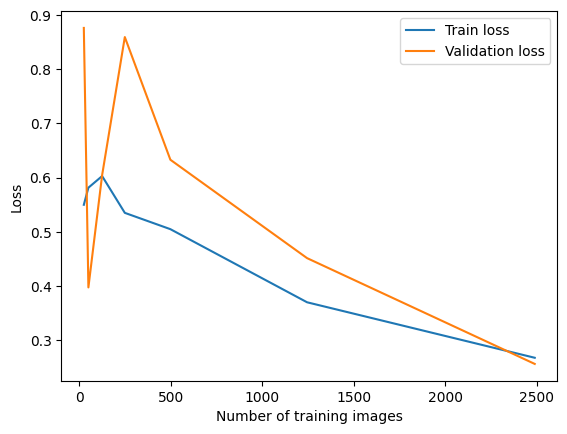

In [ ]:
sizes = [int(train_percentage * len(train_images)) for train_percentage in train_percentages]

plt.plot(sizes, train_losses_over_sizes, label="Train loss")
plt.plot(sizes, val_losses_over_sizes, label="Validation loss")
plt.legend(loc="best")
plt.xlabel("Number of training images")
plt.ylabel("Loss")
plt.show()

In [ ]:
def compute_tp_fp_tn_fn(model, loader, device, threshold):
    tp = fp = tn = fn = 0

    model.eval()

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)

            print(f"Evaluating batch {batch_idx}/{len(loader)}")

            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > threshold).float()

            tp += ((outputs == 1) & (labels == 1)).sum().item()
            fp += ((outputs == 1) & (labels == 0)).sum().item()
            tn += ((outputs == 0) & (labels == 0)).sum().item()
            fn += ((outputs == 0) & (labels == 1)).sum().item()

    return tp, fp, tn, fn

In [ ]:
thresholds = np.linspace(0, 1, 20)
best_threshold = 0.0
best_f1_score = 0.0
eps = 1e-8

for threshold in thresholds:
    print(f"Testing threshold: {threshold:.4f}")

    tp, fp, tn, fn = compute_tp_fp_tn_fn(model, val_loader, DEVICE, threshold)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1_score = 2 * precision * recall / (precision + recall + eps)

    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_threshold = threshold

tp, fp, tn, fn = compute_tp_fp_tn_fn(model, test_loader, DEVICE, best_threshold)
precision = tp / (tp + fp + eps)
recall = tp / (tp + fn + eps)
f1_score = 2 * precision * recall / (precision + recall + eps)
total_accuracy = (tp + tn) / (tp + fp + tn + fn)

print("Results on test set")
print(f"Best threshold: {best_threshold:.4f}")
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")
print(f"Total accuracy: {total_accuracy:.4f}")

Testing threshold: 0.0000


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/156
Evaluating batch 1/156
Evaluating batch 2/156
Evaluating batch 3/156
Evaluating batch 4/156
Evaluating batch 5/156
Evaluating batch 6/156
Evaluating batch 7/156
Evaluating batch 8/156
Evaluating batch 9/156
Evaluating batch 10/156
Evaluating batch 11/156
Evaluating batch 12/156
Evaluating batch 13/156
Evaluating batch 14/156
Evaluating batch 15/156
Evaluating batch 16/156
Evaluating batch 17/156
Evaluating batch 18/156
Evaluating batch 19/156
Evaluating batch 20/156
Evaluating batch 21/156
Evaluating batch 22/156
Evaluating batch 23/156
Evaluating batch 24/156
Evaluating batch 25/156
Evaluating batch 26/156
Evaluating batch 27/156
Evaluating batch 28/156
Evaluating batch 29/156
Evaluating batch 30/156
Evaluating batch 31/156
Evaluating batch 32/156
Evaluating batch 33/156
Evaluating batch 34/156
Evaluating batch 35/156
Evaluating batch 36/156
Evaluating batch 37/156
Evaluating batch 38/156
Evaluating batch 39/156
Evaluating batch 40/156
Evaluating batch 41/156
Ev

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating batch 0/389
Evaluating batch 1/389
Evaluating batch 2/389
Evaluating batch 3/389
Evaluating batch 4/389
Evaluating batch 5/389
Evaluating batch 6/389
Evaluating batch 7/389
Evaluating batch 8/389
Evaluating batch 9/389
Evaluating batch 10/389
Evaluating batch 11/389
Evaluating batch 12/389
Evaluating batch 13/389
Evaluating batch 14/389
Evaluating batch 15/389
Evaluating batch 16/389
Evaluating batch 17/389
Evaluating batch 18/389
Evaluating batch 19/389
Evaluating batch 20/389
Evaluating batch 21/389
Evaluating batch 22/389
Evaluating batch 23/389
Evaluating batch 24/389
Evaluating batch 25/389
Evaluating batch 26/389
Evaluating batch 27/389
Evaluating batch 28/389
Evaluating batch 29/389
Evaluating batch 30/389
Evaluating batch 31/389
Evaluating batch 32/389
Evaluating batch 33/389
Evaluating batch 34/389
Evaluating batch 35/389
Evaluating batch 36/389
Evaluating batch 37/389
Evaluating batch 38/389
Evaluating batch 39/389
Evaluating batch 40/389
Evaluating batch 41/389
Ev

In [ ]:
def show_batch(model, loader, device, threshold):
    batch = next(iter(loader))
    data, target = batch
    data, target = data.to(device), target.to(device)

    model.eval()
    with torch.no_grad():
        output = model(data)
        output = torch.sigmoid(output)
        thresholded_output = (output > threshold).float()

    output = output.cpu().numpy()
    thresholded_output = thresholded_output.cpu().numpy()
    target = target.cpu().numpy()
    data = data.cpu().numpy()

    for i in range(len(output)):
        _, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(data[i, 3, :, :], cmap="gray")
        ax[1].imshow(target[i, 0, :, :], vmin=0, vmax=1, cmap="gray")
        ax[2].imshow(output[i, 0, :, :], vmin=0, vmax=1, cmap="gray")
        ax[3].imshow(thresholded_output[i, 0, :, :], vmin=0, vmax=1, cmap="gray")
        plt.show()

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


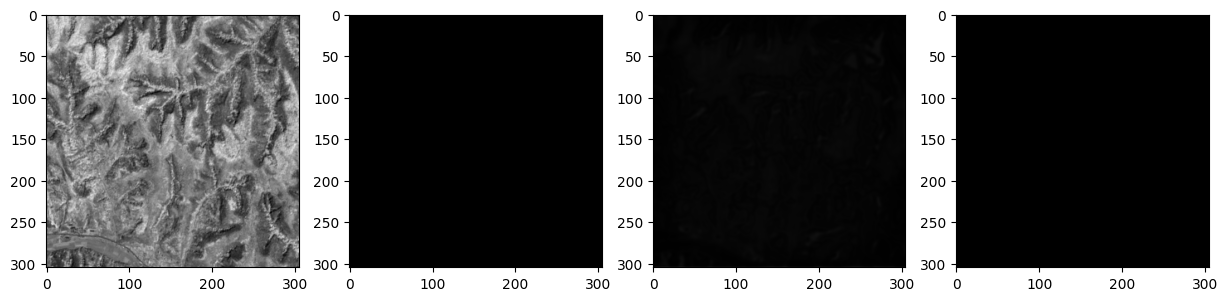

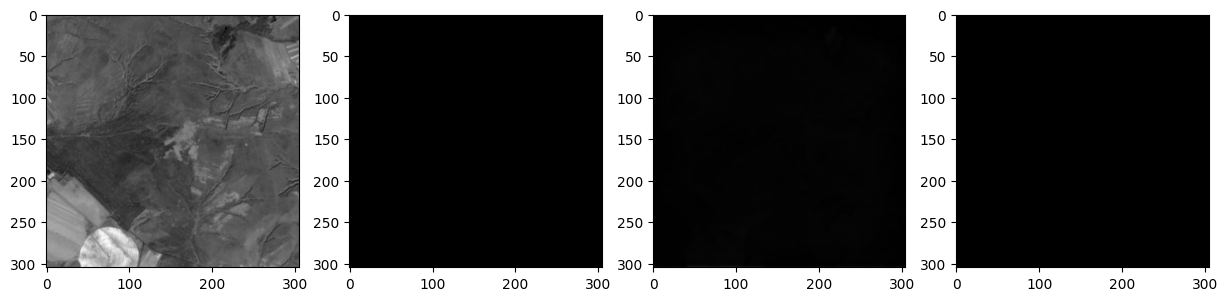

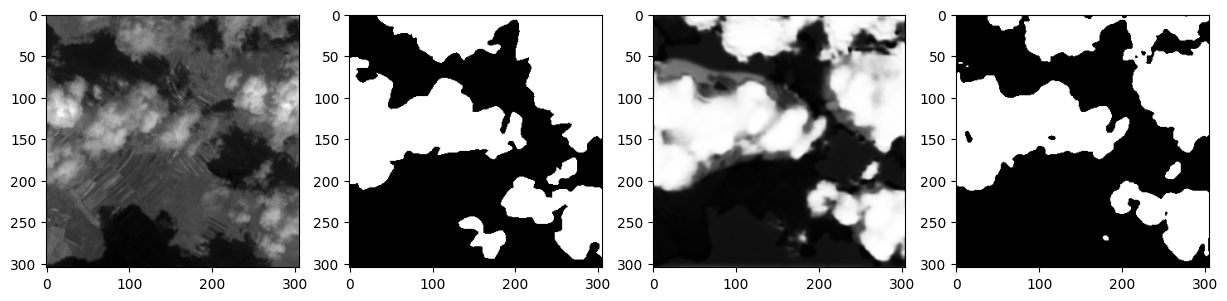

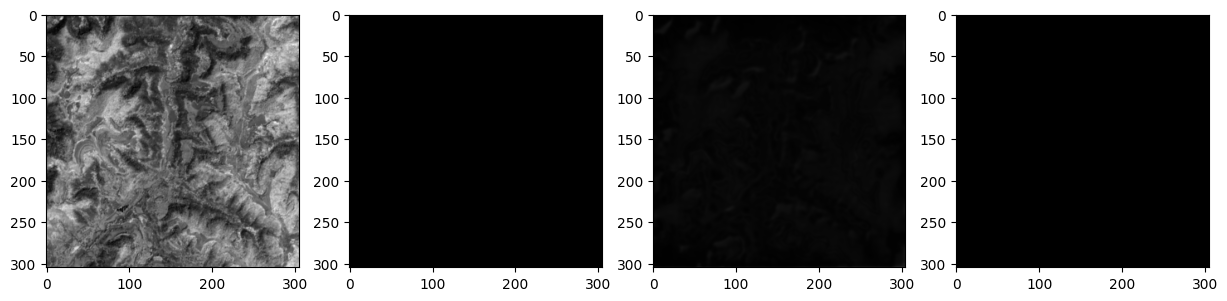

In [ ]:
show_batch(model, val_loader, DEVICE, best_threshold)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


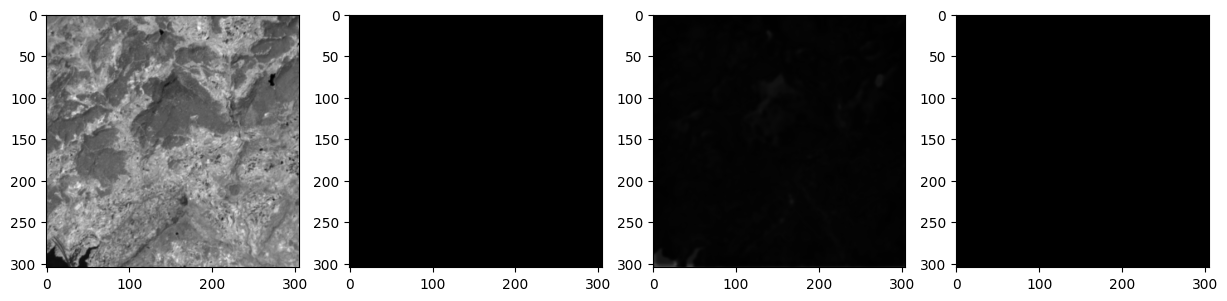

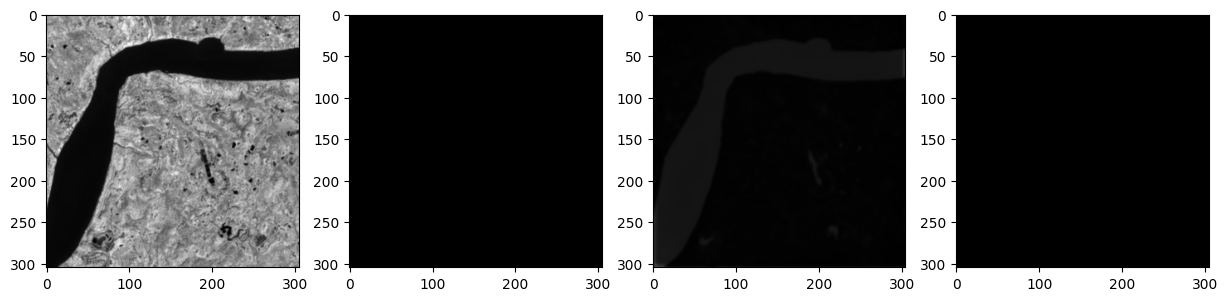

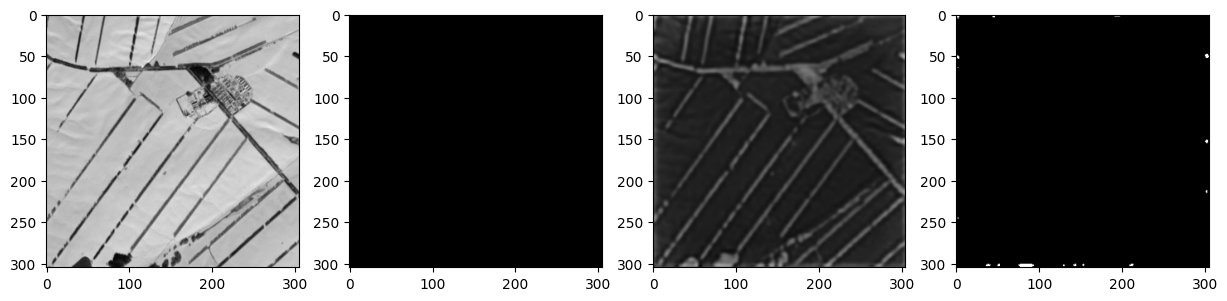

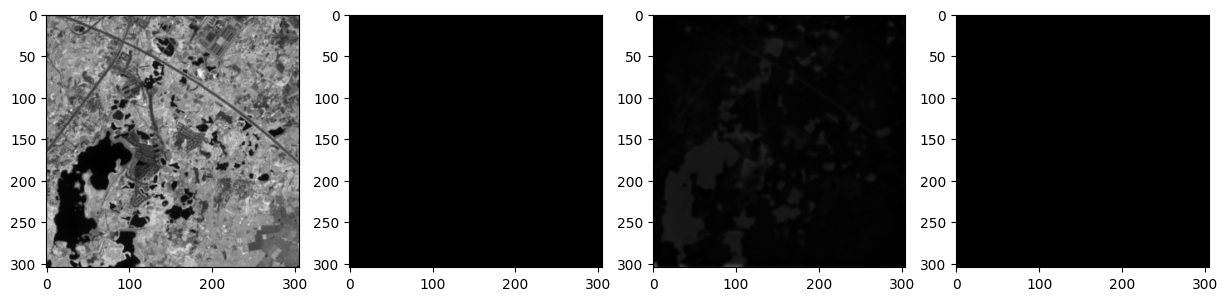

In [ ]:
show_batch(model, test_loader, DEVICE, best_threshold)